To setup the environment run the following commands on kaggle

In [1]:
!cp /kaggle/input/a3-1-1/A3/environment.yml /kaggle/working/
!cp /kaggle/input/a3-1-1/A3/install.sh /kaggle/working/

!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!


Run your .py file on CLI using the following command

In [2]:
# !python bird.py path_to_dataset train bird.pth

In [3]:
# !python bird.py path_to_dataset test bird.pth

# Models to be tested

### Preprocessing

1. Load Images as tensors ✅ 
2. Transform the images  
    - Padding ❌
    - Cropping ❌
    - Resize-ing ✅ 
3. Scale the images ✅ 
4. Normalize the images ✅ 

### Model Training

- Normal Architecture with EffNet scaling laws ✅
  > Compound Scaling Method ✅
- Add BatchNorm ✅
- Scale the network
- Add Skip Connections
- Scale the network
- Try ResNet Like Architecture
- Try GoogleNet like Architecture
- Try Data Augmentation
  1. Random Cropping
  2. Flipping and turning
  3. Brightness/contrast adjustments
  4. Aspect Ratio Jitter
  5. Colour Jitter
  6. `Albumentations`
  7. Try Adaptive Augmentation Methods
- Try Removing Classimbalance by
  1. Data Augmentation + OverSampling
  2. Weighted Classification
  3. Focal Loss
- Learning Rate Schedulers
  1. `StepLR`
  2. `CyclicLR`
  3. `OneCylceLR`
  4. Try Learning Rate WarmUp
- Try Label Smoothing
- Try DropBlock and DropOut see which is better
- Check for Gradient Clipping 

### Model Callibration

- Try Model Calibration
  1. Temperature Scaling for Calibration
  2. Calbration with Brier Score
 
### Visualization and Debugging

- Grad-CAM
- TensorBoard
- Weights and Biases
- Update Ratios

In [4]:
# !pip list | grep pandas & pip list | grep numpy

# Train and Test Loaders

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import torch
from sklearn.metrics import f1_score

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the subfolders (0, 1, ..., 9).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate over each subdirectory (0, 1, ..., 9)
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Calculating the Mean and Std for the dataset

In [8]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Define a simple transformation to just convert images to tensors
# transform = transforms.Compose([
#     transforms.Resize((528, 528)),
#     transforms.ToTensor()
# ])

# # Load your dataset (replace with your dataset path)
# dataset = ImageDataset(root_dir="/kaggle/input/identify-the-birds/Birds/train", transform=transform)
# loader = DataLoader(dataset, batch_size=200, shuffle=False)

# # Function to calculate mean and std
# def calculate_mean_std(loader):
#     mean = 0.0
#     std = 0.0
#     total_images = 0

#     for images, _ in loader:
#         batch_samples = images.size(0)  # Batch size (number of images in the batch)
#         images = images.view(batch_samples, images.size(1), -1)  # Flatten the height and width
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images += batch_samples

#     mean /= total_images
#     std /= total_images
#     return mean, std

# mean, std = calculate_mean_std(loader)

# print(f"Mean: {mean}")
# print(f"Std: {std}")

Size - (224, 224)
> Mean: tensor([0.4838, 0.4930, 0.4104]) \
Std: tensor([0.1881, 0.1875, 0.1886]

Size - (528, 528)
> Mean: tensor([0.4839, 0.4930, 0.4104]) \
Std: tensor([0.1924, 0.1919, 0.1931]))

# Loading Data

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4838, 0.493, 0.4104], std=[0.1881, 0.1875, 0.1886])
])

In [10]:
root_dir = "/kaggle/input/identify-the-birds/Birds"
train_dir = os.path.join(root_dir, "train")

dataset = ImageDataset(root_dir=train_dir, transform=transform)

labels = dataset.labels
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

## Splitting Data

In [11]:
for train_idx, test_idx in split.split(dataset.image_paths, labels):
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

In [12]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# EDA

torch.Size([64, 3, 224, 224])


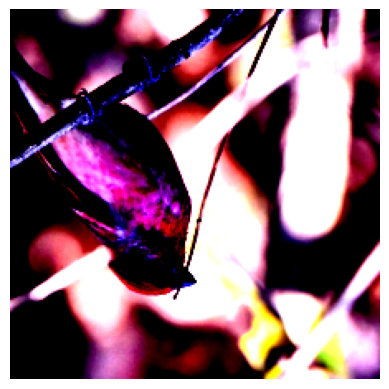

torch.Size([64])
0
torch.Size([64, 3, 224, 224])


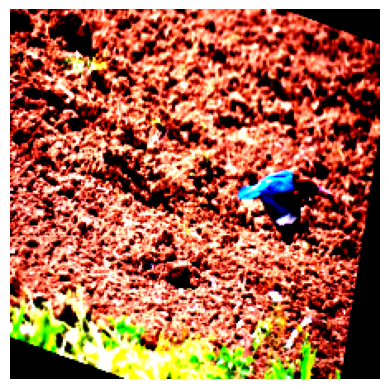

torch.Size([64])
1
torch.Size([64, 3, 224, 224])


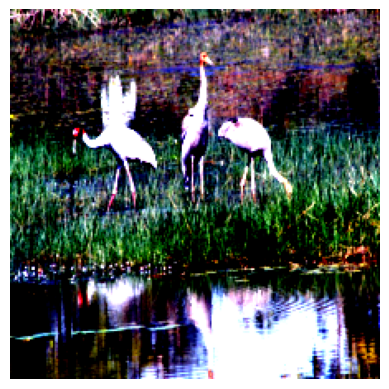

torch.Size([64])
2
torch.Size([64, 3, 224, 224])


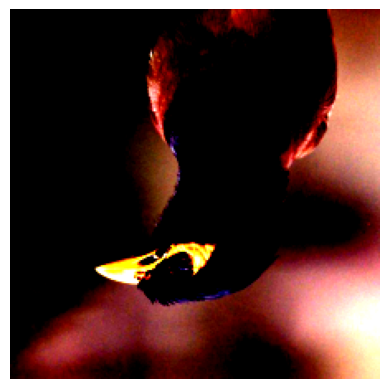

torch.Size([64])
3
torch.Size([64, 3, 224, 224])


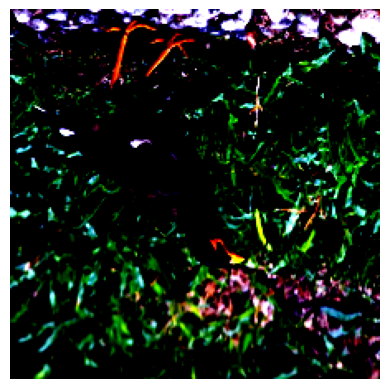

torch.Size([64])
4
torch.Size([64, 3, 224, 224])


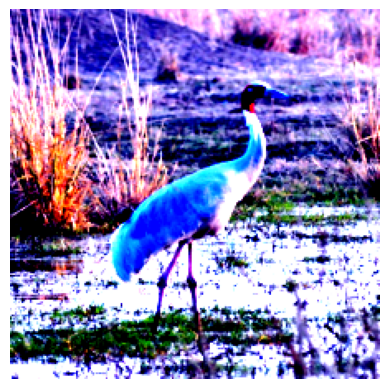

torch.Size([64])
5
torch.Size([64, 3, 224, 224])


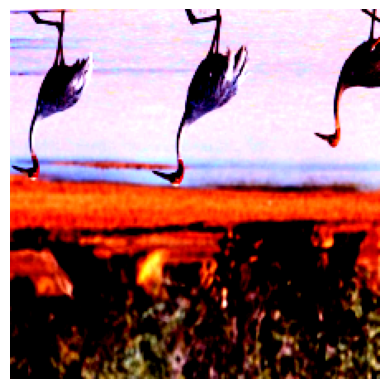

torch.Size([64])
6


In [13]:
for idx, (images, labels) in enumerate(train_loader):
    print(images.shape)

    # printing the image to see
    image_numpy = images[0].permute(1, 2, 0).numpy()
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()
    
    print(labels.shape)
    print(idx)
    if (idx > 5):
        break

### Getting a Base Line Model to run, to check what input size gives the best results

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import argparse
import os

In [15]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # Initial convolution
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Layer 1
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),

            # Layer 2
            ResNetBlock(64, 128, stride=2),
            ResNetBlock(128, 128),

            # Layer 3
            ResNetBlock(128, 256, stride=2),
            ResNetBlock(256, 256),

            # Layer 4
            ResNetBlock(256, 512, stride=2),
            ResNetBlock(512, 512),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 10),  # Adjust the output layer for 8 classes
        )

    def forward(self, x):
        return self.model(x)

In [16]:
# ----------------- model training ----------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Available device: {device}")

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
print(f"No. of model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Available device: cuda
No. of model parameters: 11186442


In [17]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|     model.0.weight     |    9408    |
|      model.0.bias      |     64     |
|     model.1.weight     |     64     |
|      model.1.bias      |     64     |
|  model.4.conv1.weight  |   36864    |
|   model.4.conv1.bias   |     64     |
|   model.4.bn1.weight   |     64     |
|    model.4.bn1.bias    |     64     |
|  model.4.conv2.weight  |   36864    |
|   model.4.conv2.bias   |     64     |
|   model.4.bn2.weight   |     64     |
|    model.4.bn2.bias    |     64     |
|  model.5.conv1.weight  |   36864    |
|   model.5.conv1.bias   |     64     |
|   model.5.bn1.weight   |     64     |
|    model.5.bn1.bias    |     64     |
|  model.5.conv2.weight  |   36864    |
|   model.5.conv2.bias   |     64     |
|   model.5.bn2.weight   |     64     |
|    model.5.bn2.bias    |     64     |
|  model.6.conv1.weight  |   73728    |
|   model.6.conv1.bias   |    128     |


11186442

In [18]:
from torch.optim.lr_scheduler import StepLR

# Define optimizer and StepLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays learning rate by 0.1 every 5 epochs

# Training loop
num_epochs = 5

# Initialize logging
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
train_f1_scores, test_f1_scores = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_train, y_pred_train = [], []  # To store true labels and predictions for F1 score

    # Training phase
    for images, labels in train_loader:
        images = images.to(device).float()  # Move images to GPU
        labels = labels.to(device).long()   # Move labels to GPU

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation for training data
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate true labels and predictions for F1 score
        y_true_train.extend(labels.cpu().numpy())  # Move labels back to CPU
        y_pred_train.extend(predicted.cpu().numpy())  # Move predictions back to CPU

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Compute F1 score for training
    f1_macro_train = f1_score(y_true_train, y_pred_train, average='macro')
    f1_micro_train = f1_score(y_true_train, y_pred_train, average='micro')
    f1_train = (f1_macro_train + f1_micro_train) / 2

    # Append training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(f1_train)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_test, y_pred_test = [], []  # To store true labels and predictions for F1 score

    with torch.no_grad():  # No need to calculate gradients during validation
        for images, labels in test_loader:
            images = images.to(device).float()  # Move images to GPU
            labels = labels.to(device).long()   # Move labels to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Accuracy calculation for test data
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulate true labels and predictions for F1 score
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total

    # Compute F1 score for validation
    f1_macro_test = f1_score(y_true_test, y_pred_test, average='macro')
    f1_micro_test = f1_score(y_true_test, y_pred_test, average='micro')
    f1_test = (f1_macro_test + f1_micro_test) / 2

    # Append test metrics
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    test_f1_scores.append(f1_test)

    # Adjust learning rate
#     scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Train F1: {f1_train:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {f1_test:.4f}')

Epoch [1/5], Train Loss: 1.3857, Train Acc: 0.5023, Train F1: 0.5000, Test Loss: 3.0811, Test Acc: 0.3574, Test F1: 0.3256
Epoch [2/5], Train Loss: 0.8101, Train Acc: 0.7252, Train F1: 0.7237, Test Loss: 0.8549, Test Acc: 0.7339, Test F1: 0.7311
Epoch [3/5], Train Loss: 0.5652, Train Acc: 0.8186, Train F1: 0.8171, Test Loss: 0.9020, Test Acc: 0.7204, Test F1: 0.7088
Epoch [4/5], Train Loss: 0.4137, Train Acc: 0.8661, Train F1: 0.8644, Test Loss: 1.0289, Test Acc: 0.6832, Test F1: 0.6746
Epoch [5/5], Train Loss: 0.2871, Train Acc: 0.9108, Train F1: 0.9090, Test Loss: 0.7658, Test Acc: 0.7791, Test F1: 0.7738


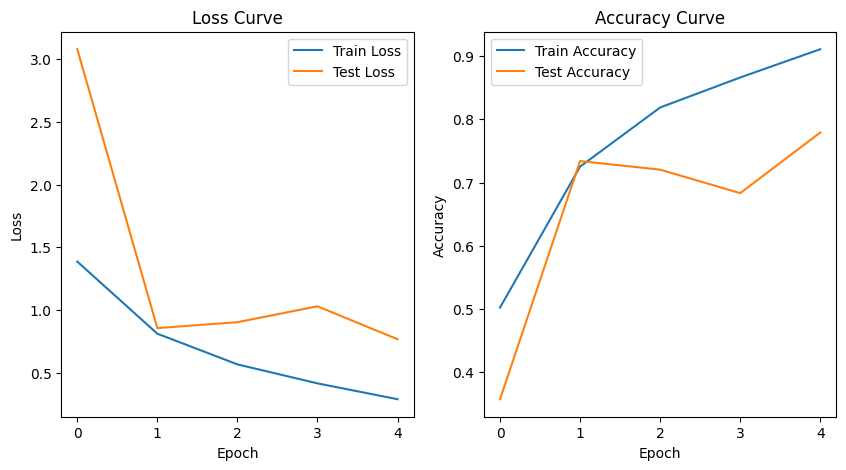

In [19]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to calculate and plot confusion matrix
def plot_confusion_matrix(loader, model, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
plot_confusion_matrix(test_loader, model, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 43.12 MiB is free. Process 2519 has 15.84 GiB memory in use. Of the allocated memory 15.00 GiB is allocated by PyTorch, and 554.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)